Martín Amado - 19020
Juan Pablo Pineda - 19087

Referencia para análisis de datos: https://www.kaggle.com/competitions/digit-recognizer/data?select=test.csv

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import numpy as np
import itertools
import matplotlib.cm as cm
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.layers import LSTM
from scipy import stats
from factor_analyzer import calculate_bartlett_sphericity, calculate_kmo
from sklearn.decomposition import PCA
from keras.utils.np_utils import to_categorical
from sklearn.pipeline import make_pipeline
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from apyori import apriori

np.warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning)
sns.set(style='white', context='notebook', palette='deep')

# Ejercicio 1

In [3]:
digitRec_train = pd.read_csv("./train.csv")
digitRec_test = pd.read_csv("./test.csv")

In [4]:
digitRec_train

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41996,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41997,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41998,6,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
digitRec_test

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
27996,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
27997,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
27998,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Analisis Exploratorio

In [6]:
baseMatrix = digitRec_train.to_numpy()

### Testing de imagenes

In [7]:
from PIL import Image

img = Image.new('RGB', (28, 28), "black")
numbersMatrices = []

for x in baseMatrix[:5]:
    localmat = []
    for pixel in range(1, len(x), 28):
        localmat.append(list(x[pixel:pixel+28]))
    for row in range(0,28):
        for col in range(0,28):
            img.putpixel((col,row), (localmat[row][col], localmat[row][col], localmat[row][col]))
    numbersMatrices.append(localmat)
    img.show()


## Pre-procesamiento de los datos

c:\Users\juanp\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


1    4684
7    4401
3    4351
9    4188
2    4177
6    4137
0    4132
4    4072
8    4063
5    3795
Name: label, dtype: int64

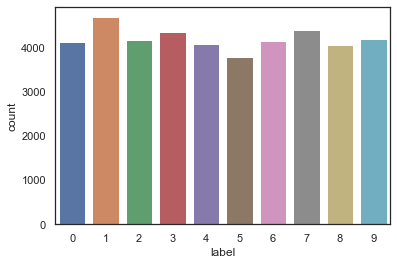

In [8]:
Y_train = digitRec_train['label']
X_train = digitRec_train.drop(['label'], axis=1)

g = sns.countplot(Y_train)

Y_train.value_counts()

In [9]:
X_train.isnull().any().describe()

count       784
unique        1
top       False
freq        784
dtype: object

In [10]:
digitRec_test.isnull().any().describe()

count       784
unique        1
top       False
freq        784
dtype: object

In [11]:
X_train = X_train / 255.0
digitRec_test = digitRec_test / 255.0

In [12]:
X_train = X_train.values.reshape(-1,28,28,1)
digitRec_test = digitRec_test.values.reshape(-1,28,28,1)

In [15]:
Y_train = to_categorical(Y_train, num_classes = 10)

In [16]:
random_seed = 2
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size = 0.1, random_state=random_seed)

### Primer Modelo de Red Neuronal

In [18]:
model = Sequential()

model.add(Conv2D(filters=32, kernel_size=(5, 5), padding='Same',
                 activation='relu', input_shape=(28, 28, 1)))
model.add(Conv2D(filters=32, kernel_size=(5, 5), padding='Same',
                 activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))


model.add(Conv2D(filters=64, kernel_size=(3, 3), padding='Same',
                 activation='relu'))
model.add(Conv2D(filters=64, kernel_size=(3, 3), padding='Same',
                 activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Dropout(0.25))


model.add(Flatten())
model.add(Dense(256, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(10, activation="softmax"))


### Optimizacion del modelo

In [19]:
optimizer = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])

In [29]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [22]:
epochs = 1 # Turn epochs to 30 to get 0.9967 accuracy
batch_size = 86

In [23]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images

datagen.fit(X_train)

In [30]:
history = model.fit_generator(datagen.flow(X_train, Y_train, batch_size=batch_size),
                              epochs=epochs, validation_data=(X_val, Y_val),
                              verbose=2, steps_per_epoch=X_train.shape[0] // batch_size, callbacks=[learning_rate_reduction])


C:\Users\juanp\AppData\Local\Temp\ipykernel_4760\526121071.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(datagen.flow(X_train, Y_train, batch_size=batch_size),


439/439 - 85s - loss: 0.1326 - accuracy: 0.9618 - val_loss: 0.0481 - val_accuracy: 0.9864 - lr: 0.0010 - 85s/epoch - 194ms/step


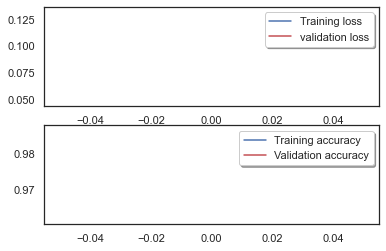

In [31]:
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['accuracy'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

132/132 [==============================] - 2s 11ms/step


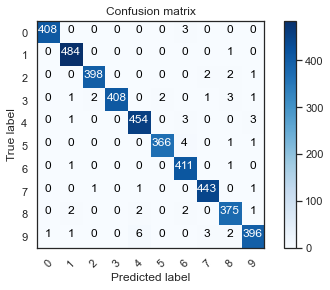

In [34]:

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Predict the values from the validation dataset
Y_pred = model.predict(X_val)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(Y_val,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(10)) 

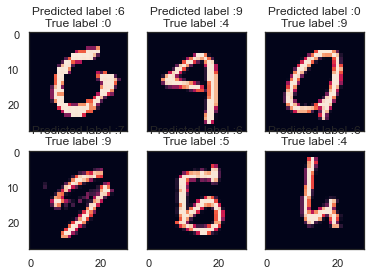

In [35]:
errors = (Y_pred_classes - Y_true != 0)

Y_pred_classes_errors = Y_pred_classes[errors]
Y_pred_errors = Y_pred[errors]
Y_true_errors = Y_true[errors]
X_val_errors = X_val[errors]

def display_errors(errors_index,img_errors,pred_errors, obs_errors):
    """ This function shows 6 images with their predicted and real labels"""
    n = 0
    nrows = 2
    ncols = 3
    fig, ax = plt.subplots(nrows,ncols,sharex=True,sharey=True)
    for row in range(nrows):
        for col in range(ncols):
            error = errors_index[n]
            ax[row,col].imshow((img_errors[error]).reshape((28,28)))
            ax[row,col].set_title("Predicted label :{}\nTrue label :{}".format(pred_errors[error],obs_errors[error]))
            n += 1

# Probabilities of the wrong predicted numbers
Y_pred_errors_prob = np.max(Y_pred_errors,axis = 1)

# Predicted probabilities of the true values in the error set
true_prob_errors = np.diagonal(np.take(Y_pred_errors, Y_true_errors, axis=1))

# Difference between the probability of the predicted label and the true label
delta_pred_true_errors = Y_pred_errors_prob - true_prob_errors

# Sorted list of the delta prob errors
sorted_dela_errors = np.argsort(delta_pred_true_errors)

# Top 6 errors 
most_important_errors = sorted_dela_errors[-6:]

# Show the top 6 errors
display_errors(most_important_errors, X_val_errors, Y_pred_classes_errors, Y_true_errors)

### Predicciones

In [37]:
results = model.predict(digitRec_test)

# select the indix with the maximum probability
results = np.argmax(results,axis = 1)

results = pd.Series(results,name="Label")

875/875 [==============================] - 9s 10ms/step


In [39]:
digitRec_test

array([[[[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        ...,

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]]],


       [[[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        ...,

        [[0.],
 

# Ejercicio 2

## Parte 1: Series de tiempo

### Consumos Diesel

Recaudacion y limpieza de datos

In [ ]:
consumption = pd.read_excel('./CONSUMO-2022-05.xlsx', skiprows=6)
consumption = consumption[['Fecha', 'Diesel']]
#omitimos los datos despues del 269 ya que no aportan relevancia
consumption = consumption[:269]

Desarrollo de la seria de tiempo

In [ ]:
trainSize = int(len(consumption) * 0.7)
trainConsumos = consumption[0:trainSize]
testConsumos = consumption[trainSize:len(consumption)]
trainConsumos = trainConsumos.set_index(['Fecha'])
testConsumos = testConsumos.set_index(['Fecha'])

In [ ]:
tsDiesel = trainConsumos['Diesel']
mediaMovil = tsDiesel.rolling(window=12).mean()
deMovil = tsDiesel.rolling(window=12).std()

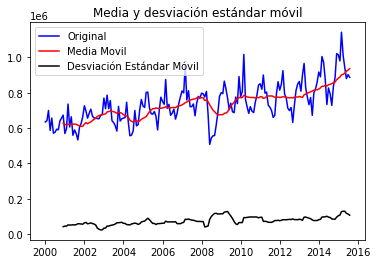

In [ ]:
original = plt.plot(tsDiesel, color="blue", label="Original")
media = plt.plot(mediaMovil, color='red', label = 'Media Movil')
ds = plt.plot(deMovil,color='black', label = 'Desviación Estándar Móvil')
plt.legend(loc = 'best')
plt.title('Media y desviación estándar móvil')
plt.show(block=False)

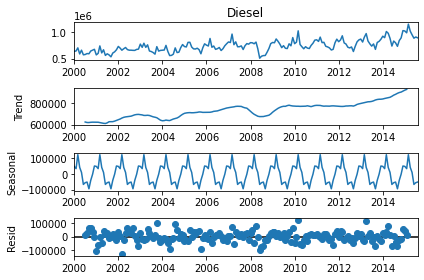

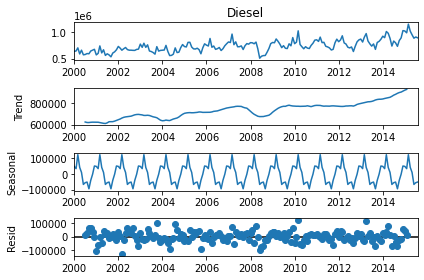

In [ ]:
descomposicion = seasonal_decompose(tsDiesel)
descomposicion.plot()

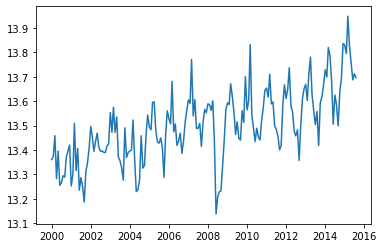

In [ ]:
tsDiesel = tsDiesel.astype({'Diesel':'float'})
tsDieselLog = np.log(tsDiesel)
plt.plot(tsDieselLog)

In [ ]:
dfTest = adfuller(tsDiesel, autolag='AIC')
salidaDf = pd.Series(dfTest[0:4], index=['Estadístico de prueba','p-value','# de retardos usados','# de observaciones usadas'])
for key,value in dfTest[4].items():
        salidaDf['Valor Crítico (%s)'%key] = value
print(salidaDf)

Estadístico de prueba         -0.141801
p-value                        0.945112
# de retardos usados          12.000000
# de observaciones usadas    175.000000
Valor Crítico (1%)            -3.468280
Valor Crítico (5%)            -2.878202
Valor Crítico (10%)           -2.575653
dtype: float64


In [ ]:
tsDieselDiff = tsDiesel.diff()
tsDieselDiff.fillna(0,inplace=True)
dfTest = adfuller(tsDieselDiff)
salidaDf = pd.Series(dfTest[0:4], index=['Estadístico de prueba','p-value','# de retardos usados','# de observaciones usadas'])
for key,value in dfTest[4].items():
        salidaDf['Critical Value (%s)'%key] = value
salidaDf

Estadístico de prueba         -5.546664
p-value                        0.000002
# de retardos usados          11.000000
# de observaciones usadas    176.000000
Critical Value (1%)           -3.468062
Critical Value (5%)           -2.878106
Critical Value (10%)          -2.575602
dtype: float64

Text(0.5, 1.0, 'Diferenciacion de la serie')

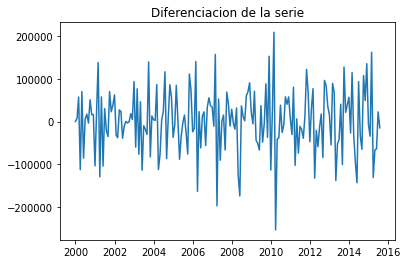

In [ ]:
plt.plot(tsDieselDiff)
plt.title('Diferenciacion de la serie')

In [ ]:
modelo111 = SARIMAX(tsDieselLog, order=(1,1,1), seasonal_order=(3,1,0,12), enforce_stationarity=False, enforce_invertibility=False)
resultado_m111 = modelo111.fit()
resultado_m111.summary().tables[1]

c:\Users\juanp\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\juanp\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


,coef,std err,z,P>|z|,[0.025,0.975]
ar.L1,0.0315,0.162,0.194,0.846,-0.286,0.349
ma.L1,-0.6126,0.119,-5.152,0.000,-0.846,-0.380
ar.S.L12,-0.7276,0.087,-8.382,0.000,-0.898,-0.557
ar.S.L24,-0.5636,0.103,-5.480,0.000,-0.765,-0.362
ar.S.L36,-0.3038,0.086,-3.527,0.000,-0.473,-0.135
sigma2,0.0048,0.000,11.515,0.000,0.004,0.006


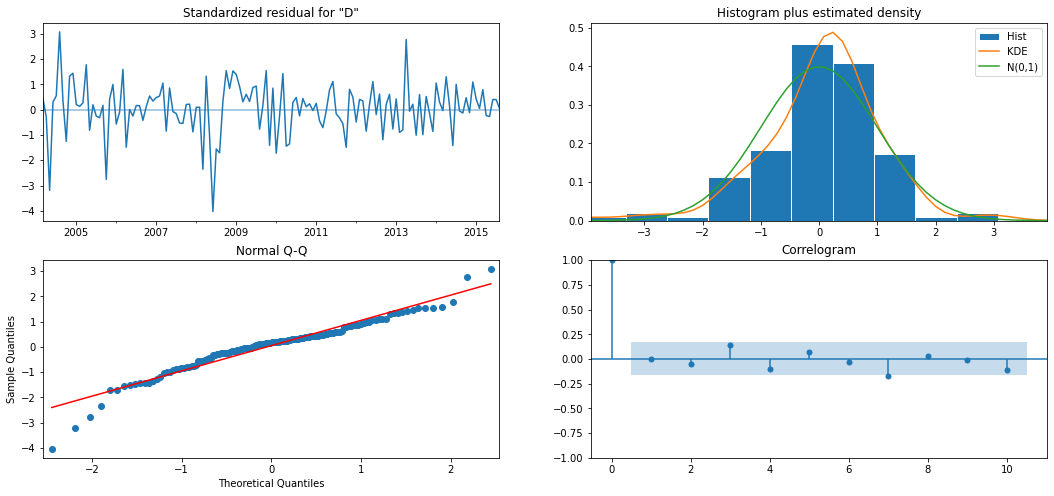

In [ ]:
resultado_m111.plot_diagnostics(figsize=(18, 8))
plt.show()

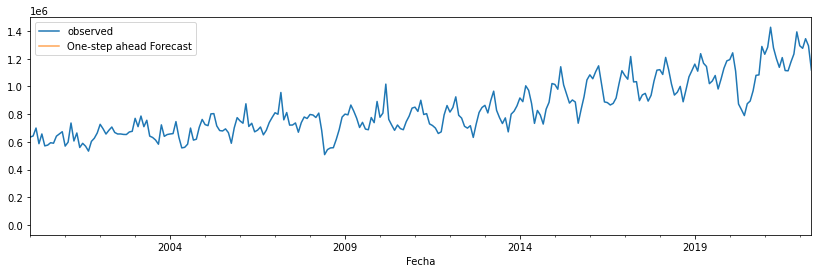

In [ ]:
testConsumos.index[0]
pred = resultado_m111.get_prediction(start=testConsumos.index[0], dynamic=False)
pred_ci = pred.conf_int()
consumoIndexed = consumption.set_index('Fecha')
consumoIndexed = consumoIndexed['Diesel']
ax = consumoIndexed['2000':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 4))
ax.fill_between( pred_ci.iloc[:,0],
                pred_ci.iloc[:,1], color='k', alpha=.2)
#ax.set_xlabel('Date')
#ax.set_ylabel('Retail_sold')
plt.legend()
plt.show()

pred

## Parte 2: LSTM

In [ ]:
consumo = pd.read_excel('./CONSUMO-2022-05.xlsx', skiprows=6)
consumo = consumo[['Fecha', 'Diesel']]
#omitimos los datos despues del 269 ya que no aportan relevancia
consumo = consumo[:269]
consumo = consumo.set_index('Fecha')
consumo.head()

,Diesel
Fecha,
2000-01-01,634667.06
2000-02-01,642380.66
2000-03-01,699807.25
2000-04-01,586803.98
2000-05-01,656948.2


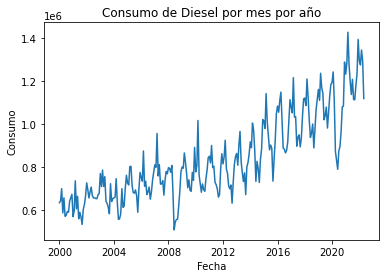

In [ ]:
plt.plot(consumo)
plt.gca().set(title="Consumo de Diesel por mes por año", xlabel="Fecha", ylabel="Consumo")
plt.show()

Estacionarizar para uso de LSTM

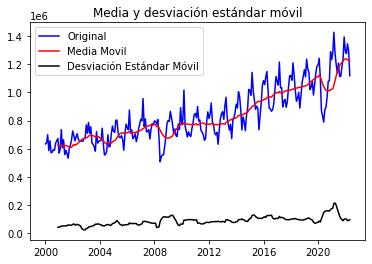

In [ ]:
# Se calcula la media móvil y la desviación estandar móvil de los últimos 12 meses.
mediaMovil = consumo.rolling(window=12).mean()
deMovil = consumo.rolling(window=12).std()
# Se grafican los resultados.
original = plt.plot(consumo, color="blue", label="Original")
media = plt.plot(mediaMovil, color='red', label = 'Media Movil')
ds = plt.plot(deMovil,color='black', label = 'Desviación Estándar Móvil')
plt.legend(loc = 'best')
plt.title('Media y desviación estándar móvil')
plt.show(block=False)

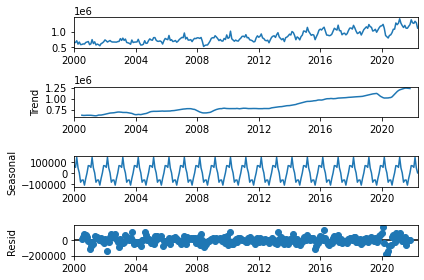

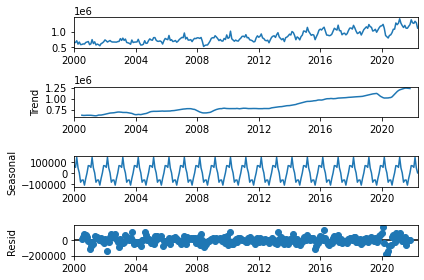

In [ ]:
descomposicion = seasonal_decompose(consumo)
descomposicion.plot()

Existe tendencia

In [ ]:
print('Resultados del Test de Dickey Fuller')
dfTest = adfuller(consumo, autolag='AIC')
salidaDf = pd.Series(dfTest[0:4], index=['Estadístico de prueba','p-value','# de retardos usados','# de observaciones usadas'])
for key,value in dfTest[4].items():
        salidaDf['Critical Value (%s)'%key] = value
print(salidaDf)

Resultados del Test de Dickey Fuller
Estadístico de prueba         -0.046948
p-value                        0.954473
# de retardos usados          12.000000
# de observaciones usadas    256.000000
Critical Value (1%)           -3.456155
Critical Value (5%)           -2.872897
Critical Value (10%)          -2.572822
dtype: float64


In [ ]:
print('Resultados del Test de Dickey Fuller para una diferenciación de la serie')
diesel_diff = consumo.diff()
diesel_diff.fillna(0,inplace=True)
dfTest = adfuller(diesel_diff)
salidaDf = pd.Series(dfTest[0:4], index=['Estadístico de prueba','p-value','# de retardos usados','# de observaciones usadas'])
for key,value in dfTest[4].items():
        salidaDf['Critical Value (%s)'%key] = value
print(salidaDf)

Resultados del Test de Dickey Fuller para una diferenciación de la serie
Estadístico de prueba       -6.528469e+00
p-value                      1.000760e-08
# de retardos usados         1.100000e+01
# de observaciones usadas    2.570000e+02
Critical Value (1%)         -3.456054e+00
Critical Value (5%)         -2.872853e+00
Critical Value (10%)        -2.572799e+00
dtype: float64


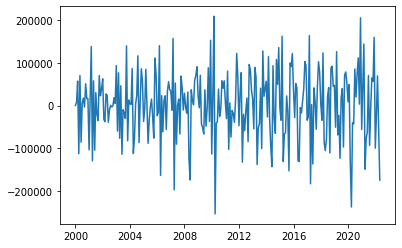

In [ ]:
plt.plot(diesel_diff)

Necesidad de diferenciacion

In [ ]:
scaler = StandardScaler()
diesel_scaled = scaler.fit_transform(diesel_diff) 
diesel_scaled[1:7]

array([[ 0.07505497],
       [ 0.70616145],
       [-1.45744589],
       [ 0.86761179],
       [-1.11499886],
       [ 0.04715821]])

60% entrenamiento, 20% validacion y prueba

In [ ]:
train_diesel = round(0.6*len(diesel_scaled))
val_test_diesel = round(0.2*len(diesel_scaled))
test = diesel_scaled[(train_diesel + val_test_diesel) - 1:]
validation = diesel_scaled[(train_diesel):train_diesel + val_test_diesel + 1]
train = diesel_scaled[0:train_diesel]
train = np.insert(train, 0, 0)
train = np.reshape(train, (train.shape[0], 1))

Transformacion a serie supervisada

In [ ]:
from operator import concat


def supervisada(serie,retrasos = 1):
    serie_x = []
    serie_y = []
    for i in range(len(serie)-retrasos):
        valor = serie[i:(i+retrasos),0]
        valor_sig = serie[i+retrasos,0]
        serie_x.append(valor)
        serie_y.append(valor_sig)
    return np.array(serie_x), np.array(serie_y)

x_train,y_train = supervisada(train)
x_val,y_val = supervisada(validation)
x_test,y_test = supervisada(test)

#### Creacion de modelo

##### Modelo 1

Matrices de 3 dimensiones

In [ ]:
x_train = np.reshape(x_train,(x_train.shape[0],1,1))
x_val = np.reshape(x_val, (x_val.shape[0],1,1))
x_test = np.reshape(x_test, (x_test.shape[0],1,1))

Modelo con una capa LSTM

In [ ]:
modelo1 = Sequential()
lote = 1
unidades =  1
paso = 1
caracteristicas = 1 #es univariada
modelo1.add(LSTM(lote, batch_input_shape=(lote,paso,caracteristicas),stateful=True))
modelo1.add(Dense(1))
modelo1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (1, 1)                    12        
                                                                 
 dense (Dense)               (1, 1)                    2         
                                                                 
Total params: 14
Trainable params: 14
Non-trainable params: 0
_________________________________________________________________


In [ ]:
modelo1.compile(loss='mean_squared_error',optimizer="rmsprop")

Entrenamiento

In [ ]:
epocas = 50
history= modelo1.fit(
    x = x_train,
    y = y_train,
    batch_size = lote,
    epochs = epocas,
    shuffle = False,
    validation_data = (x_val,y_val),
    verbose=1
)

Epoch 1/50
161/161 [==============================] - 2s 5ms/step - loss: 0.8075 - val_loss: 1.1877
Epoch 2/50
161/161 [==============================] - 0s 1ms/step - loss: 0.8024 - val_loss: 1.1828
Epoch 3/50
161/161 [==============================] - 0s 1ms/step - loss: 0.7969 - val_loss: 1.1783
Epoch 4/50
161/161 [==============================] - 0s 1ms/step - loss: 0.7911 - val_loss: 1.1741
Epoch 5/50
161/161 [==============================] - 0s 1ms/step - loss: 0.7850 - val_loss: 1.1704
Epoch 6/50
161/161 [==============================] - 0s 1ms/step - loss: 0.7785 - val_loss: 1.1673
Epoch 7/50
161/161 [==============================] - 0s 1ms/step - loss: 0.7719 - val_loss: 1.1647
Epoch 8/50
161/161 [==============================] - 0s 1ms/step - loss: 0.7651 - val_loss: 1.1630
Epoch 9/50
161/161 [==============================] - 0s 1ms/step - loss: 0.7583 - val_loss: 1.1620
Epoch 10/50
161/161 [==============================] - 0s 1ms/step - loss: 0.7516 - val_loss: 1.1621

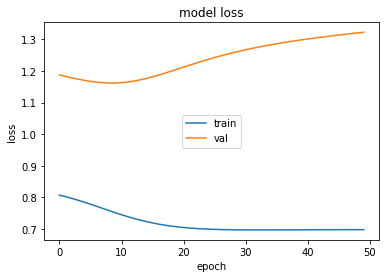

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='center')

In [ ]:
print("Pérdida en Entrenamiento")
modelo1.evaluate(
    x = x_train,
    y = y_train
)
print("Pérdida en Validación")
modelo1.evaluate(
    x = x_val,
    y = y_val
)
print("Pérdida en Prueba")
modelo1.evaluate(
    x = x_test,
    y = y_test
)

Pérdida en Entrenamiento
6/6 [==============================] - 0s 600us/step - loss: 0.8501
Pérdida en Validación
2/2 [==============================] - 0s 2ms/step - loss: 1.2429
Pérdida en Prueba
2/2 [==============================] - 0s 2ms/step - loss: 1.5938


1.593815565109253

Prediccion modelo 1

In [ ]:
prediccion_val = []

def prediccion_fun(data,modelo, batch_size,scaler,dif=False,dif_cant=1, Series = None , n=1):
    prediccion = [0]* (len(data))
    i=0
    for X in data:
        X = np.reshape(X,(1,1,1))
        yhat = modelo1.predict(X, batch_size=batch_size,verbose=0)
        # invert scaling
        yhat = scaler.inverse_transform(yhat)
        if dif:
             # invert differencing
            yhat  = yhat + Series[(n+dif_cant*i)]
        # store
        prediccion[i]=yhat[0][0]
        i = i+1
    return prediccion
prediccion_val = prediccion_fun(x_val,modelo1, 1,scaler,dif=True,dif_cant=1, Series = consumo.values , n=train_diesel)
prediccion_test = prediccion_fun(x_test,modelo1, 1,scaler,dif=True,dif_cant=1, Series = consumo.values , n=train_diesel+val_test_diesel)


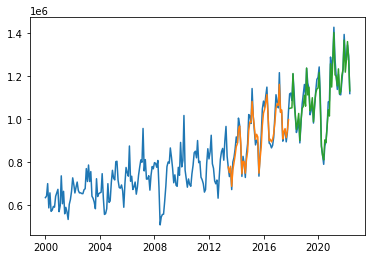

In [ ]:
df_val = pd.DataFrame(prediccion_val,index=consumo[(train_diesel):train_diesel+val_test_diesel].index)
df_test = pd.DataFrame(prediccion_test,index=consumo[train_diesel+len(df_val):len(consumo)].index)


plt.plot(consumo)
plt.plot(df_val)
plt.plot(df_test)

##### Modelo 2

Para el modelo 2, las unidades cambiaran

In [ ]:
modelo2 = Sequential()
lote = 1
unidades =  5
paso = 1
caracteristicas = 1 #es univariada
modelo2.add(LSTM(lote, batch_input_shape=(lote,paso,caracteristicas),stateful=True))
modelo2.add(Dense(1))
modelo2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (1, 1)                    12        
                                                                 
 dense_1 (Dense)             (1, 1)                    2         
                                                                 
Total params: 14
Trainable params: 14
Non-trainable params: 0
_________________________________________________________________


In [ ]:
modelo2.compile(loss='mean_squared_error',optimizer="rmsprop")

In [ ]:
epocas = 50
history= modelo2.fit(
    x = x_train,
    y = y_train,
    batch_size = lote,
    epochs = epocas,
    shuffle = False,
    validation_data = (x_val,y_val),
    verbose=1
)

Epoch 1/50
161/161 [==============================] - 1s 3ms/step - loss: 0.8223 - val_loss: 1.2022
Epoch 2/50
161/161 [==============================] - 0s 1ms/step - loss: 0.8192 - val_loss: 1.2006
Epoch 3/50
161/161 [==============================] - 0s 1ms/step - loss: 0.8158 - val_loss: 1.1990
Epoch 4/50
161/161 [==============================] - 0s 1ms/step - loss: 0.8122 - val_loss: 1.1973
Epoch 5/50
161/161 [==============================] - 0s 1ms/step - loss: 0.8083 - val_loss: 1.1957
Epoch 6/50
161/161 [==============================] - 0s 1ms/step - loss: 0.8044 - val_loss: 1.1941
Epoch 7/50
161/161 [==============================] - 0s 1ms/step - loss: 0.8004 - val_loss: 1.1927
Epoch 8/50
161/161 [==============================] - 0s 1ms/step - loss: 0.7965 - val_loss: 1.1914
Epoch 9/50
161/161 [==============================] - 0s 1ms/step - loss: 0.7926 - val_loss: 1.1902
Epoch 10/50
161/161 [==============================] - 0s 1ms/step - loss: 0.7887 - val_loss: 1.1892

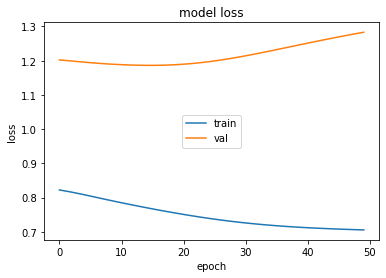

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='center')

In [ ]:
print("Pérdida en Entrenamiento")
modelo2.evaluate(
    x = x_train,
    y = y_train
)
print("Pérdida en Validación")
modelo2.evaluate(
    x = x_val,
    y = y_val
)
print("Pérdida en Prueba")
modelo2.evaluate(
    x = x_test,
    y = y_test
)

Pérdida en Entrenamiento
6/6 [==============================] - 0s 1ms/step - loss: 0.8404
Pérdida en Validación
2/2 [==============================] - 0s 2ms/step - loss: 1.2258
Pérdida en Prueba
2/2 [==============================] - 0s 2ms/step - loss: 1.5234


1.5234462022781372

In [ ]:
prediccion_val = []

def prediccion_fun(data,modelo, batch_size,scaler,dif=False,dif_cant=1, Series = None , n=1):
    prediccion = [0]* (len(data))
    i=0
    for X in data:
        X = np.reshape(X,(1,1,1))
        yhat = modelo1.predict(X, batch_size=batch_size,verbose=0)
        # invert scaling
        yhat = scaler.inverse_transform(yhat)
        if dif:
             # invert differencing
            yhat  = yhat + Series[(n+dif_cant*i)]
        # store
        prediccion[i]=yhat[0][0]
        i = i+1
    return prediccion
prediccion_val = prediccion_fun(x_val,modelo1, 1,scaler,dif=True,dif_cant=1, Series = consumo.values , n=train_diesel)
prediccion_test = prediccion_fun(x_test,modelo1, 1,scaler,dif=True,dif_cant=1, Series = consumo.values , n=train_diesel+val_test_diesel)


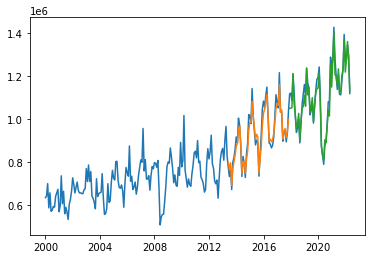

In [ ]:
df_val = pd.DataFrame(prediccion_val,index=consumo[(train_diesel):train_diesel+val_test_diesel].index)
df_test = pd.DataFrame(prediccion_test,index=consumo[train_diesel+len(df_val):len(consumo)].index)


plt.plot(consumo)
plt.plot(df_val)
plt.plot(df_test)

